In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Stability for Traditional MM model with asymptotic optimal strategy

- Fixed time step simulation
- Asymptotic optimal strategy
$$v(.; \delta^{\pm}) = \lim_{T \rightarrow +\infty} \sup_{\delta^{\pm}}\mathbb{E}_{t,x,S,Q} [X_T + Q_TS_T- \phi \int_0^T Q_u^2 du]$$

#### $Q_0 = 0$

In [397]:
T = 400
dt = 1 # time increment

sigma = 0.3 # Annual volitility of the asset
Midprice = 10 # Initial price of the asset

# Posted LO is filled with probability of e^(-kappa*depth)
kappa_sell , kappa_buy = 10**2 , 10**2
kappa = 10**2
# Arrival rate of selling MOs from other participants in market
lambda_sell = 1
# Arrival rate of buying MOs from other participants in market
lambda_buy = 1
lamda = 1
# Inventory boundary
q_upper = 50
q_lower = -50
# Risk aversion parameters
alpha = 10**-4
phi = 1*10**-5
t = np.linspace(0,T,T+1).astype(int)
length = len(t)

delta_buy = [
    1 / kappa + (2 * i + 1) * np.sqrt(phi * np.e /  lamda / kappa) / 2
    for i in range(q_upper - 1, q_lower - 1, -1)
]
delta_sell = [
    1 / kappa - (2 * i - 1) * np.sqrt(phi * np.e / lamda / kappa) / 2
    for i in range(q_upper, q_lower, -1)
]

S0 = 10
x_eta = (S0 + delta_sell[q_upper])*lamda*np.exp(-kappa*delta_sell[q_upper])- (S0+delta_buy[q_upper-1])*lamda*np.exp(-kappa*delta_buy[q_upper-1])
eta = delta_sell[q_upper]*lamda*np.exp(-kappa*delta_sell[q_upper])+ delta_buy[q_upper-1]*lamda*np.exp(-kappa*delta_buy[q_upper-1])

In [398]:
# Simulate result
Inventory = []
Cash = []
Midprice = []
iterations = 20000
W = np.zeros((iterations, length))
for iteration in range(iterations):
    S = np.zeros(length)
    X = np.zeros(length)
    Q = np.zeros(length)
    dW = np.sqrt(dt)*np.random.randn(length-1)
    W[iteration, 1:] = np.cumsum(dW)
    S[0] = S0
    X[0] = 0
    Q[0] = 0
    for i in range(length-1):
        S[i+1] = S[i] + sigma*dW[i]
        # current position
        q = int(Q[i])

        delta_sell_current = delta_sell[q_upper-q]
        delta_buy_current = delta_buy[q_upper-q-1]

        dN_sell = np.random.poisson(lamda*np.exp(-kappa*delta_sell_current)*dt)
        dN_buy = np.random.poisson(lamda*np.exp(-kappa*delta_buy_current)*dt)
        # Cash process

        X[i+1] = X[i] + (S[i]+delta_sell_current)*dN_sell - (S[i]-delta_buy_current)*dN_buy
        # Inventory process
        Q[i+1] = Q[i] + dN_buy - dN_sell

    Inventory.append(Q)
    Cash.append(X)
    Midprice.append(S)
    # calculate value function
    
inv = np.array(Inventory) 
cash = np.array(Cash)
price = np.array(Midprice)
mtm = cash + price*inv

##### Plot $Q_t$

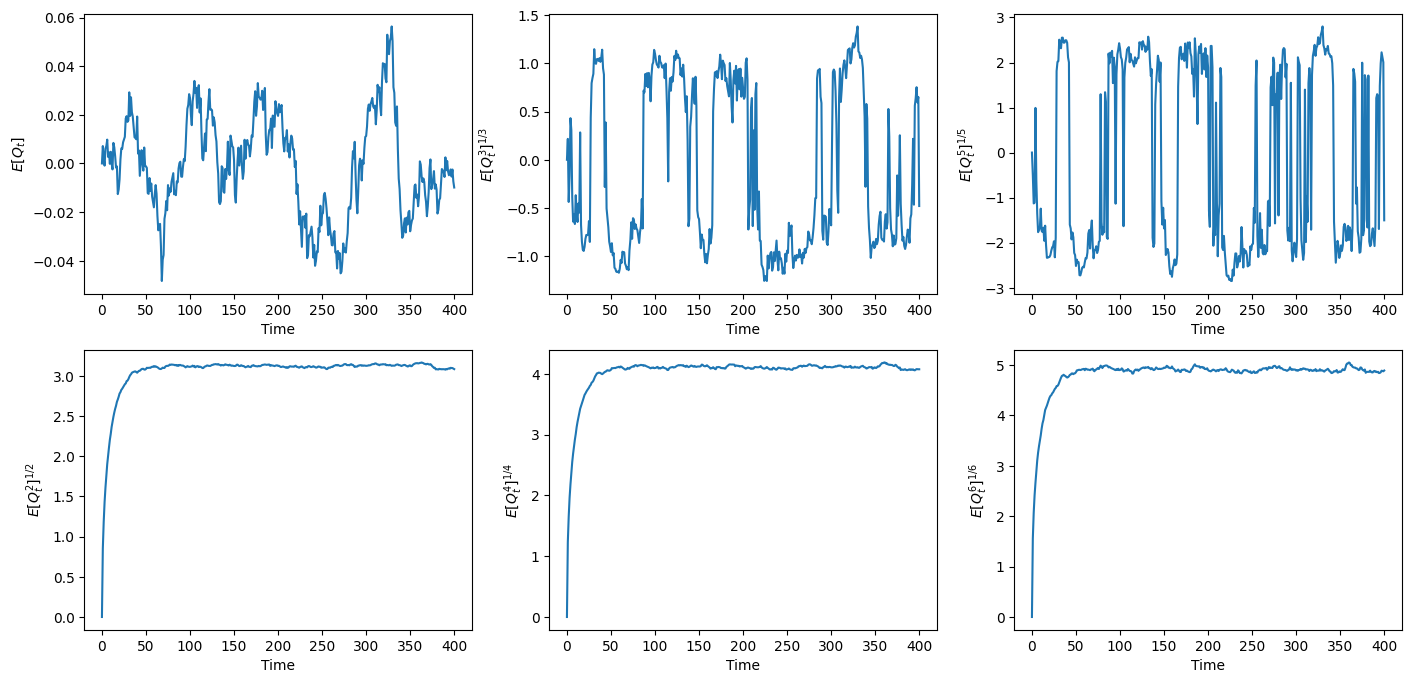

In [402]:
fig, ax = plt.subplots(2,3, figsize=(17,8))

ax[0,0].plot(t, np.mean(inv, axis=0))
ax[0,0].set_xlabel("Time")
ax[0,0].set_ylabel("$E[Q_t]$")

ax[1,0].plot(t, np.mean(inv**2, axis=0)**0.5)
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("$E[Q_t^2]^{1/2}$")

a = np.mean(inv**3, axis=0)
ax[0,1].plot(t, np.sign(a) * (np.abs(a)) ** (1 / 3))
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylabel("$E[Q_t^3]^{1/3}$")

ax[1,1].plot(t, np.mean(inv**4, axis=0)**(1/4))
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylabel("$E[Q_t^4]^{1/4}$")

a =  np.mean(inv**5, axis=0)
ax[0,2].plot(t, np.sign(a) * (np.abs(a)) ** (1 / 5))
ax[0,2].set_xlabel("Time")
ax[0,2].set_ylabel("$E[Q_t^5]^{1/5}$")

ax[1,2].plot(t, np.mean(inv**6, axis=0)**(1/6))
ax[1,2].set_xlabel("Time")
ax[1,2].set_ylabel("$E[Q_t^6]^{1/6}$")
plt.show()

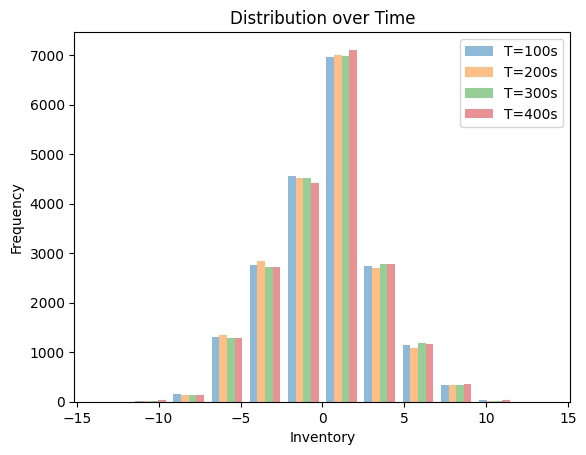

In [229]:
plt.hist([inv[:, 100], inv[:, 200], inv[:, 300],inv[:, 400]], bins=12, alpha=0.5,label=['T=100s','T=200s','T=300s','T=400s'])
plt.legend()
plt.xlabel("Inventory")
plt.ylabel("Frequency")
plt.title("Distribution over Time")
plt.show()

##### Plot $X_t + Q_t S_t$

In [312]:
a = mtm - eta*t
b = cash- x_eta*t

In [231]:
out = np.empty_like(mtm)

for time_step in t:
    mu = eta*time_step
    sigma = np.sqrt(time_step)
    out[:, time_step] = mtm[:, time_step] - (eta*time_step+W[:, time_step])

/var/folders/m0/rz86870s4n9fgqh0nzpnxf1w0000gn/T/ipykernel_74599/52966186.py:11: RuntimeWarning: invalid value encountered in power
  ax[1,0].plot(t, np.power(np.mean(cash*3, axis=0), 1.0/3))


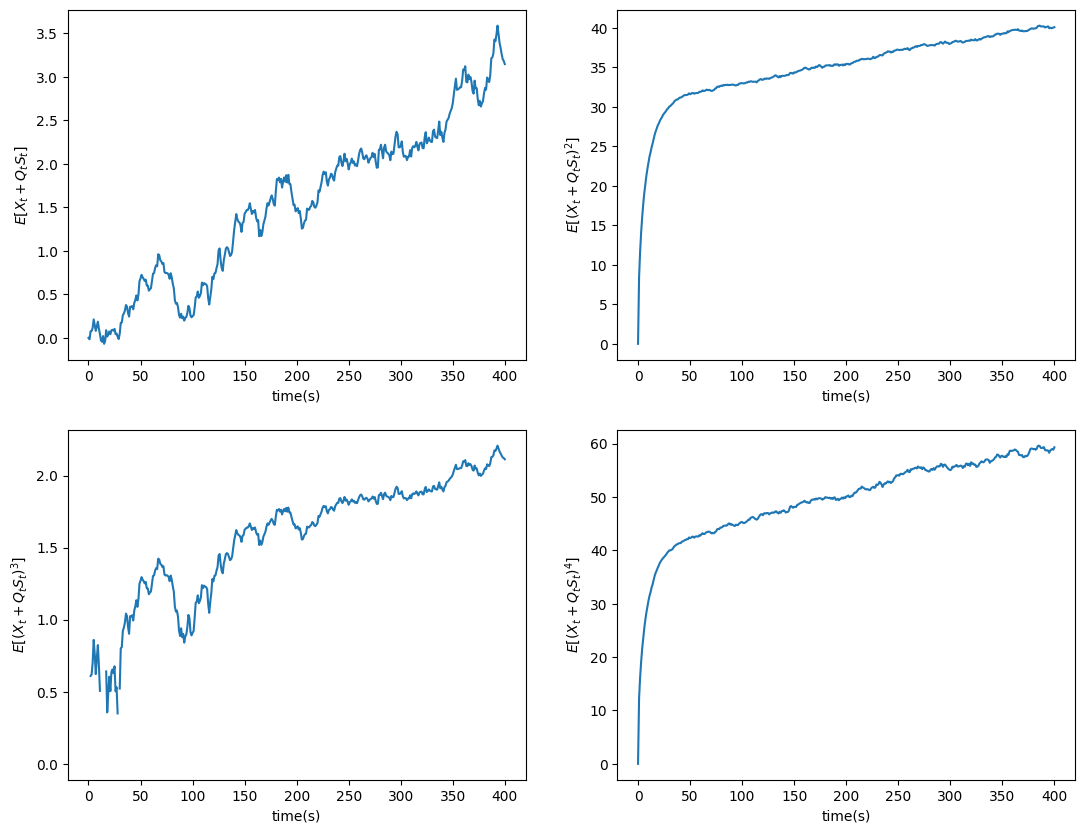

In [319]:
fig, ax = plt.subplots(2,2, figsize=(13,10))

ax[0,0].plot(t, np.mean(cash, axis=0))
ax[0,0].set_xlabel("time(s)")
ax[0,0].set_ylabel("$E[X_t + Q_t S_t]$")

ax[0,1].plot(t, np.power(np.mean(cash**2, axis=0),0.5))
ax[0,1].set_xlabel("time(s)")
ax[0,1].set_ylabel("$E[(X_t + Q_t S_t)^2]$")

ax[1,0].plot(t, np.power(np.mean(cash*3, axis=0), 1.0/3))
ax[1,0].set_xlabel("time(s)")
ax[1,0].set_ylabel("$E[(X_t + Q_t S_t)^3]$")

ax[1,1].plot(t, np.power(np.mean(cash**4, axis=0), 1.0/4))
ax[1,1].set_xlabel("time(s)")
ax[1,1].set_ylabel("$E[(X_t + Q_t S_t)^4]$")

plt.show()

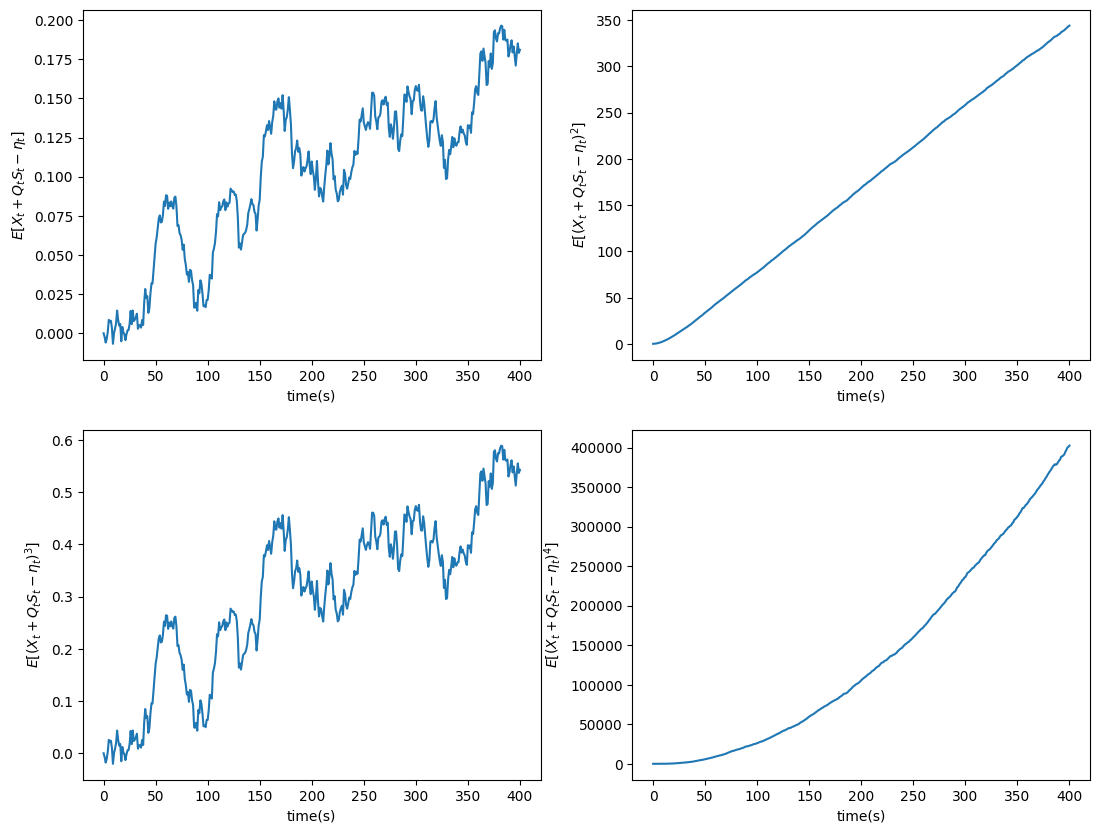

In [316]:
fig, ax = plt.subplots(2,2, figsize=(13,10))

ax[0,0].plot(t, np.mean(a, axis=0))
ax[0,0].set_xlabel("time(s)")
ax[0,0].set_ylabel("$E[X_t + Q_t S_t - \eta_t]$")

ax[0,1].plot(t, np.mean(a**2, axis=0))
ax[0,1].set_xlabel("time(s)")
ax[0,1].set_ylabel("$E[(X_t + Q_t S_t - \eta_t)^2]$")

ax[1,0].plot(t, np.mean(a*3, axis=0))
ax[1,0].set_xlabel("time(s)")
ax[1,0].set_ylabel("$E[(X_t + Q_t S_t - \eta_t)^3]$")

ax[1,1].plot(t, np.mean(a**4, axis=0))
ax[1,1].set_xlabel("time(s)")
ax[1,1].set_ylabel("$E[(X_t + Q_t S_t - \eta_t)^4]$")

plt.show()

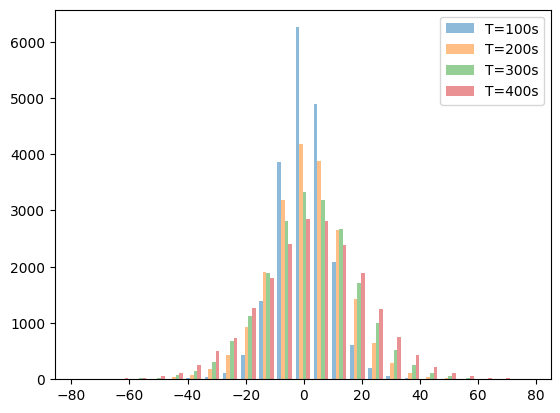

In [235]:
plt.hist([mtm[:, 100], mtm[:, 200], mtm[:, 300],mtm[:, 400]], bins=25, alpha=0.5,label=['T=100s','T=200s','T=300s','T=400s'])
plt.legend()
plt.show()

#### $Q_0 = -5$

In [307]:
# Simulate result
Inventory = []
Cash = []
Midprice = []
iterations = 20000
W = np.zeros((iterations, length))
for iteration in range(iterations):
    S = np.zeros(length)
    X = np.zeros(length)
    Q = np.zeros(length)
    dW = np.sqrt(dt)*np.random.randn(length-1)
    W[iteration, 1:] = np.cumsum(dW)
    S[0] = S0
    X[0] = 0
    Q[0] = np.sqrt(10)*np.random.randn()
    for i in range(length-1):
        S[i+1] = S[i] + sigma*dW[i]
        # current position
        q = int(Q[i])

        delta_sell_current = delta_sell[q_upper-q]
        delta_buy_current = delta_buy[q_upper-q-1]

        dN_sell = np.random.poisson(lamda*np.exp(-kappa*delta_sell_current)*dt)
        dN_buy = np.random.poisson(lamda*np.exp(-kappa*delta_buy_current)*dt)
        # Cash process

        X[i+1] = X[i] + (S[i]+delta_sell_current)*dN_sell - (S[i]-delta_buy_current)*dN_buy
        # Inventory process
        Q[i+1] = Q[i] + dN_buy - dN_sell

    Inventory.append(Q)
    Cash.append(X)
    Midprice.append(S)
    # calculate value function
    
inv = np.array(Inventory) 
cash = np.array(Cash)
price = np.array(Midprice)
mtm = cash + price*inv

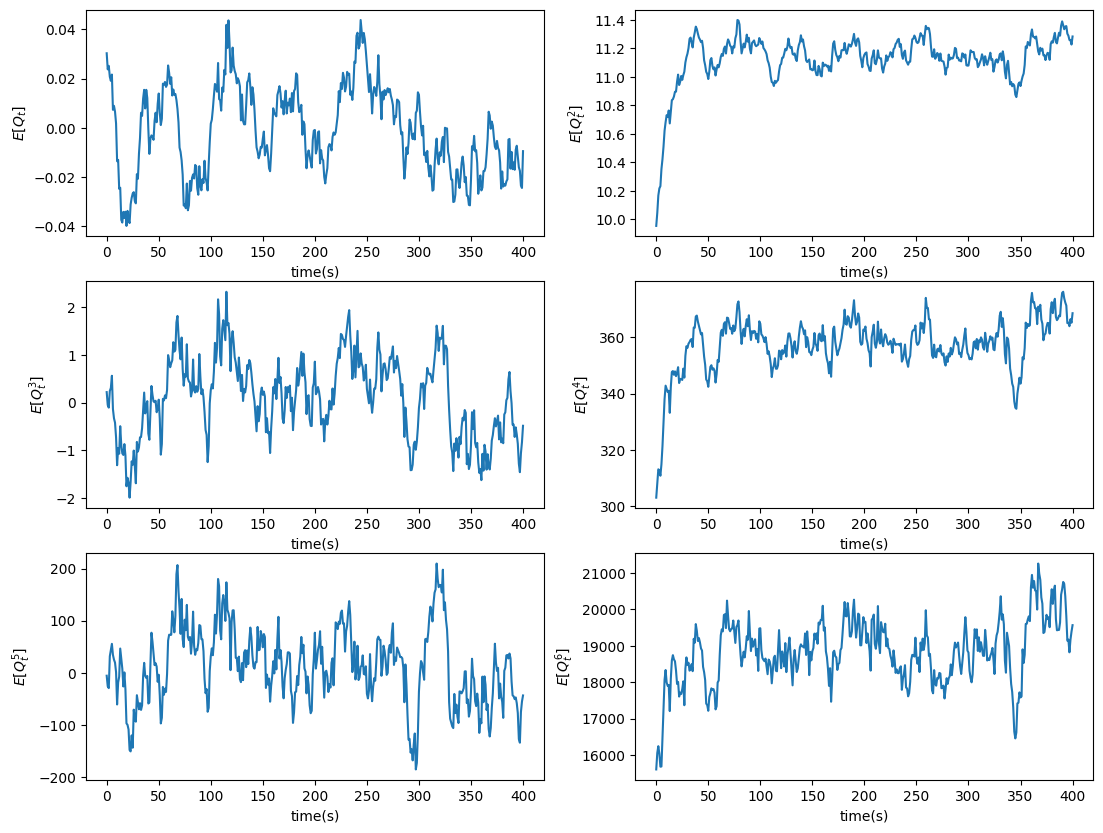

In [308]:
fig, ax = plt.subplots(3,2, figsize=(13,10))

ax[0,0].plot(t, np.mean(inv, axis=0))
ax[0,0].set_xlabel("time(s)")
ax[0,0].set_ylabel("$E[Q_t]$")

ax[0,1].plot(t, np.mean(inv**2, axis=0))
ax[0,1].set_xlabel("time(s)")
ax[0,1].set_ylabel("$E[Q_t^2]$")

ax[1,0].plot(t, np.mean(inv**3, axis=0))
ax[1,0].set_xlabel("time(s)")
ax[1,0].set_ylabel("$E[Q_t^3]$")

ax[1,1].plot(t, np.mean(inv**4, axis=0))
ax[1,1].set_xlabel("time(s)")
ax[1,1].set_ylabel("$E[Q_t^4]$")

ax[2,0].plot(t, np.mean(inv**5, axis=0))
ax[2,0].set_xlabel("time(s)")
ax[2,0].set_ylabel("$E[Q_t^5]$")

ax[2,1].plot(t, np.mean(inv**6, axis=0))
ax[2,1].set_xlabel("time(s)")
ax[2,1].set_ylabel("$E[Q_t^6]$")
plt.show()

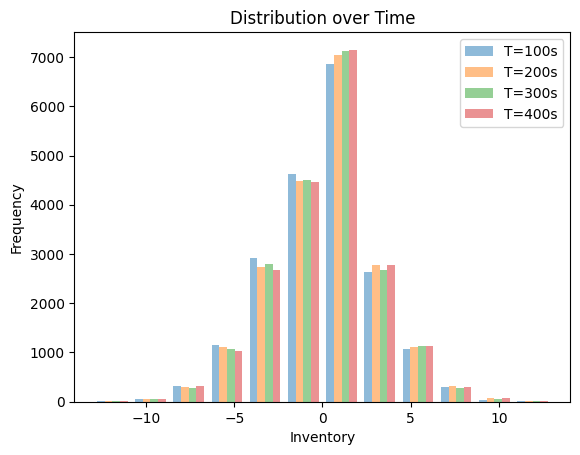

In [251]:
plt.hist([inv[:, 100], inv[:, 200], inv[:, 300],inv[:, 400]], bins=12, alpha=0.5,label=['T=100s','T=200s','T=300s','T=400s'])
plt.legend()
plt.xlabel("Inventory")
plt.ylabel("Frequency")
plt.title("Distribution over Time")
plt.show()

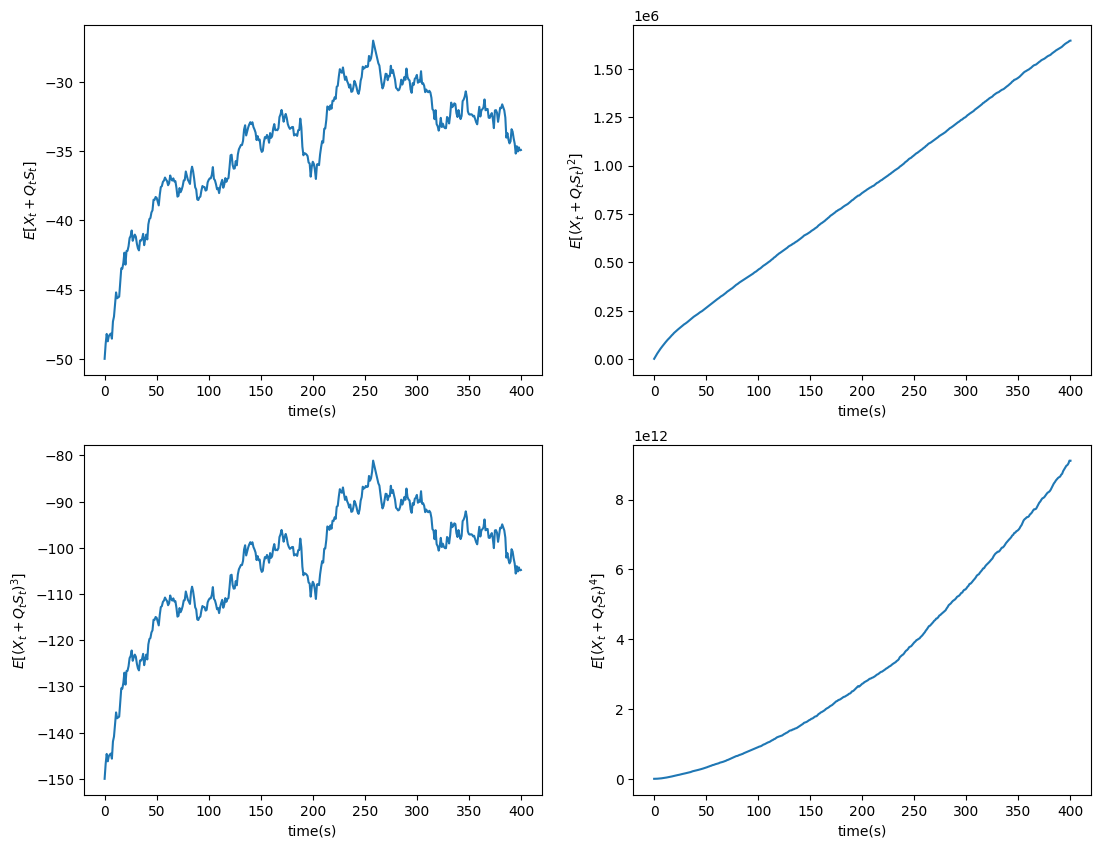

In [254]:
fig, ax = plt.subplots(2,2, figsize=(13,10))

ax[0,0].plot(t, np.mean(mtm, axis=0))
ax[0,0].set_xlabel("time(s)")
ax[0,0].set_ylabel("$E[X_t + Q_t S_t]$")

ax[0,1].plot(t, np.mean(mtm**2, axis=0))
ax[0,1].set_xlabel("time(s)")
ax[0,1].set_ylabel("$E[(X_t + Q_t S_t)^2]$")

ax[1,0].plot(t, np.mean(mtm*3, axis=0))
ax[1,0].set_xlabel("time(s)")
ax[1,0].set_ylabel("$E[(X_t + Q_t S_t)^3]$")

ax[1,1].plot(t, np.mean(mtm**4, axis=0))
ax[1,1].set_xlabel("time(s)")
ax[1,1].set_ylabel("$E[(X_t + Q_t S_t)^4]$")

plt.show()

### Stability for Vega Model with asymptotic optimal strategy

- Fixed time step simulation 
- Asymptotic optimal strategy
$$v(.; \delta^{\pm}) = \lim_{T \rightarrow +\infty} \sup_{\delta^{\pm}}\mathbb{E}_{t,x,S,Q} [X_T + Q_TS_T- \phi \int_0^T Q_u^2 du]$$

In [385]:
import torch
from torch.distributions.binomial import Binomial

def vega_model_optimal(
    S0,
    X0, 
    q, 
    lambda_buy,
    lambda_sell,
    kappa_buy,
    kappa_sell,
    optimal_bid,
    optimal_ask,
    sigma,
    T,
    time_decimal = 2,
    spread = 0.04,
    batch_size = 500, 
):
    """
    Use PyTorch
    """
    optimal_bid = torch.tensor(optimal_bid)
    optimal_ask = torch.tensor(optimal_ask)

    def Poisson_process(ts, time_decimal, intensity, batch_size):
        """
        Generate a Possion process 
        """
        intervals = (
            -torch.log(torch.rand(batch_size, int(2 * ts[-1] * intensity))) / intensity
        )
        pois_p = torch.cumsum(intervals, dim=1)
        pois_p = (pois_p * 10**time_decimal).round() / (10**time_decimal)

        if all(pois_p[:, -1] >= float(ts[-1])):
            return pois_p

        else:
            a = 2
            while not all(pois_p[:, -1] >= float(ts[-1])):
                a = a*2
                intervals = (
                    -torch.log(torch.rand(batch_size, int(a * ts[-1] * intensity)))
                    / intensity
                )
                pois_p = torch.cumsum(intervals, dim=1)
                pois_p = (pois_p * 10**time_decimal).round() / (10**time_decimal)
            return pois_p

    X = X0 * torch.ones(batch_size, 1)
    S = S0 * torch.ones(batch_size, 1)
    P = S0 * torch.ones(batch_size, 1) 
    Q = q * torch.ones(batch_size, 1) 
    # Q = torch.normal(mean=0, std=np.sqrt(9.3), size=(batch_size,1))
    
    x0 = torch.cat((X, S, P, Q), 1)
    epsilon = spread / 2

    x = x0.unsqueeze(1)

    T = int(T*10**time_decimal)

    ts = torch.linspace(0, T, T+1) / 10**time_decimal
    ts = torch.round(ts, decimals=time_decimal)

    # only process S needs brownian motion
    brownian_increments = torch.zeros(batch_size, len(ts), 1)
    time_buyMOs = Poisson_process(ts, time_decimal, lambda_buy, batch_size)
    time_sellMOs = Poisson_process(ts, time_decimal, lambda_sell, batch_size)

    h = ts[1] - ts[0]
    for idx, t in enumerate(ts[1:]):
        # x denotes the tuple (X, S, P, Q)
        P_old = x[:, -1, 2].unsqueeze(1) # (batch_size, 1)
        Q_old = x[:, -1, 3].unsqueeze(1) # (batch_size, 1)

        brownian_increments[:, idx, :] = torch.randn(
            batch_size, 1,
        ) * torch.sqrt(h)

        # Update midprice
        S_new = (
            x[:, -1, 1].unsqueeze(1) + sigma * brownian_increments[:, idx, :]
        )  # (batch_size, 1)

        sell_depth = optimal_ask.repeat(batch_size, 1)
        indices_sell = (q_upper - Q_old).to(torch.int64)
        sell_depth = sell_depth.gather(1, indices_sell)
        buy_depth = optimal_bid.repeat(batch_size, 1)
        indices_buy = (q_upper - 1 - Q_old).to(torch.int64)
        buy_depth = buy_depth.gather(1, indices_buy)

        buyMO_come = torch.sum(torch.any(time_buyMOs == t, axis=1).unsqueeze(1), axis=1).unsqueeze(1)
        prob_sellside = torch.exp(-sell_depth * kappa_sell)
        dN_sell = Binomial(buyMO_come, prob_sellside).sample() # (batch_size, 1)
        dA_sell = buyMO_come - dN_sell # (batch_size, 1)

        sellMO_come = torch.sum(torch.any(time_sellMOs == t, axis=1).unsqueeze(1), axis=1).unsqueeze(1)
        prob_buyside = torch.exp(-buy_depth * kappa_buy)
        dN_buy = Binomial(sellMO_come, prob_buyside).sample()
        dA_buy = sellMO_come - dN_buy

        # Update markprice process 
        P_new = (
            P_old + (S_new-P_old+sell_depth)*dN_sell + (S_new-P_old-buy_depth)*dN_buy + (S_new-P_old+epsilon)*dA_sell + (S_new-P_old-epsilon)*dA_buy
        ) # (batch_size, 1)        
        # Update inventory process
        Q_new = (
            x[:, -1, 3].unsqueeze(1) + dN_buy - dN_sell
        ) # (batch_size, 1)

        # Update collateral process
        X_new = (
            x[:, -1, 0].unsqueeze(1) + Q_old*(P_new - P_old)
        ) # (batch_size, 1)

        # x denotes the tuple (X, S, P, Q)
        x_new = torch.cat((X_new, S_new, P_new, Q_new), 1)  # (batch_size, 4)
        x = torch.cat([x, x_new.unsqueeze(1)], 1)  # (batch_size, N ,4)

    return x

In [323]:
T = 200
time_decimal = 2
dt = 1 / 10**time_decimal 
t = np.linspace(0, T, T*10**time_decimal+1)
t = np.round(t, time_decimal)

res = vega_model_optimal(
    S0 = S0,
    X0 = 0, 
    q = 0, 
    lambda_buy = lambda_buy,
    lambda_sell = lambda_sell,
    kappa_buy = kappa_buy,
    kappa_sell = kappa_sell,
    optimal_bid= delta_buy,
    optimal_ask = delta_sell,
    sigma = sigma,
    time_decimal=time_decimal,
    T = T,
)

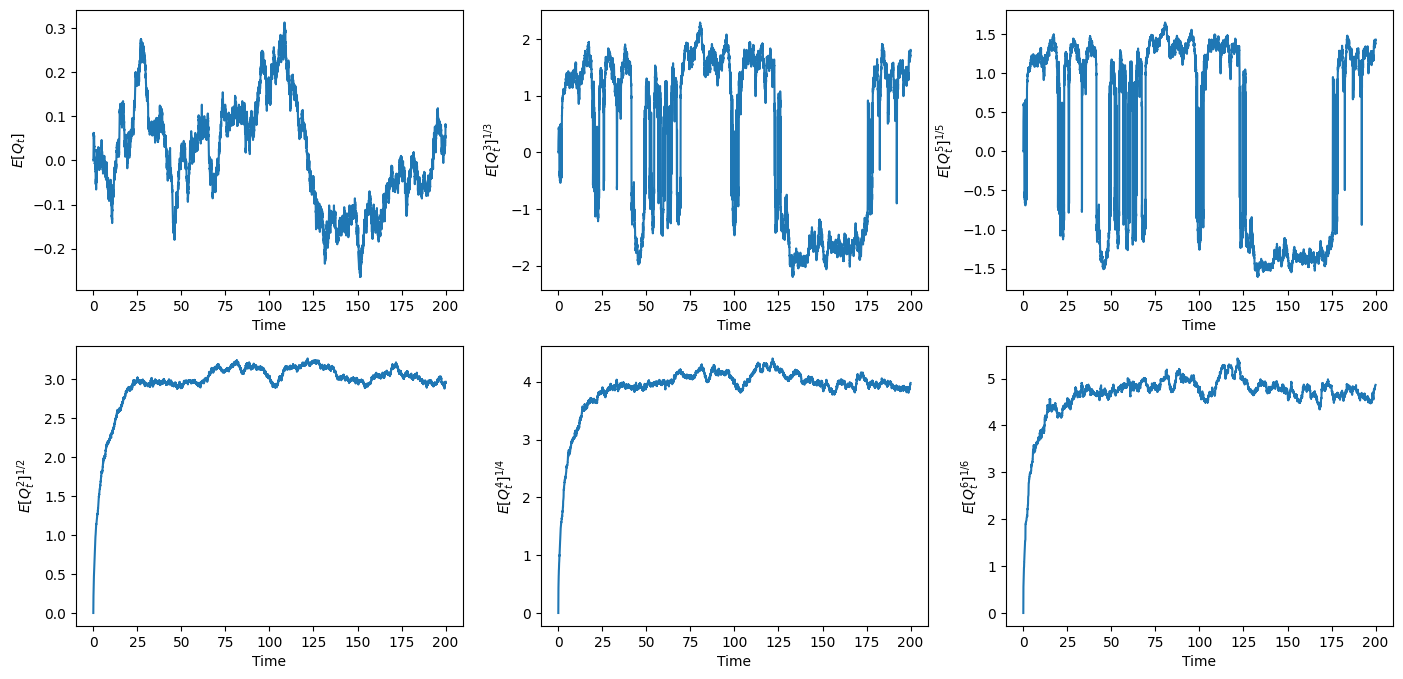

In [374]:
fig, ax = plt.subplots(2,3, figsize=(17,8))

ax[0,0].plot(t, torch.mean(res[:,:,3], axis=0))
ax[0,0].set_xlabel("Time")
ax[0,0].set_ylabel("$E[Q_t]$")

ax[1,0].plot(t, torch.pow(torch.mean(res[:,:,3]**2, axis=0), 0.5))
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("$E[Q_t^2]^{1/2}$")

a = torch.mean(res[:,:,3]**3, axis=0).numpy()
ax[0,1].plot(t, np.sign(a) * (np.abs(a)) ** (1 / 3))
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylabel("$E[Q_t^3]^{1/3}$")

ax[1,1].plot(t, torch.pow(torch.mean(res[:,:,3]**4, axis=0), 1.0/4))
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylabel("$E[Q_t^4]^{1/4}$")

torch.mean(res[:,:,3]**5, axis=0).numpy()
ax[0,2].plot(t,np.sign(a) * (np.abs(a)) ** (1 / 5))
ax[0,2].set_xlabel("Time")
ax[0,2].set_ylabel("$E[Q_t^5]^{1/5}$")

ax[1,2].plot(t, torch.pow(torch.mean(res[:,:,3]**6, axis=0), 1.0/6))
ax[1,2].set_xlabel("Time")
ax[1,2].set_ylabel("$E[Q_t^6]^{1/6}$")

plt.show()

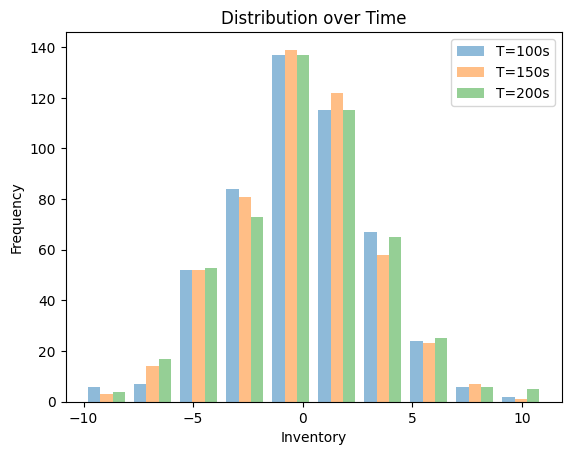

In [293]:
plt.hist([res[:, int(100/dt), 3], res[:, int(150/dt), 3], res[:, int(200/dt), 3]], bins=10, alpha=0.5,label=['T=100s','T=150s','T=200s'])
plt.legend()
plt.xlabel("Inventory")
plt.ylabel("Frequency")
plt.title("Distribution over Time")
plt.show()

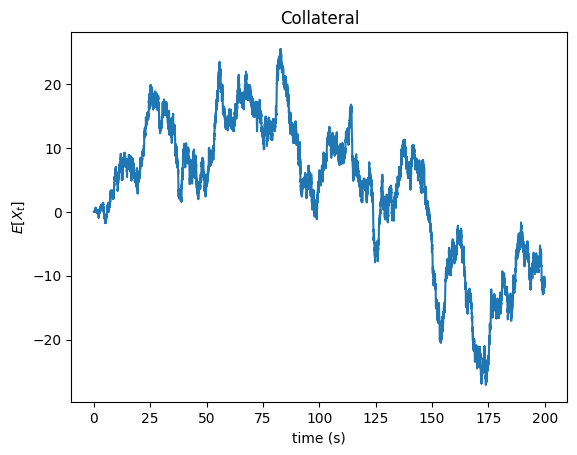

In [301]:
plt.plot(t, torch.mean(res[:,:,0], axis=0))
plt.xlabel("time (s)")
plt.ylabel("$E[X_t]$")
plt.title("Collateral")
plt.show()

#### $Q_0 = -5$

In [ ]:
res_de = vega_model_optimal(
    S0 = S0,
    X0 = 0, 
    q = -5, 
    lambda_buy = lambda_buy,
    lambda_sell = lambda_sell,
    kappa_buy = kappa_buy,
    kappa_sell = kappa_sell,
    optimal_bid= delta_buy,
    optimal_ask = delta_sell,
    sigma = sigma,
    time_decimal=time_decimal,
    T = T,
)

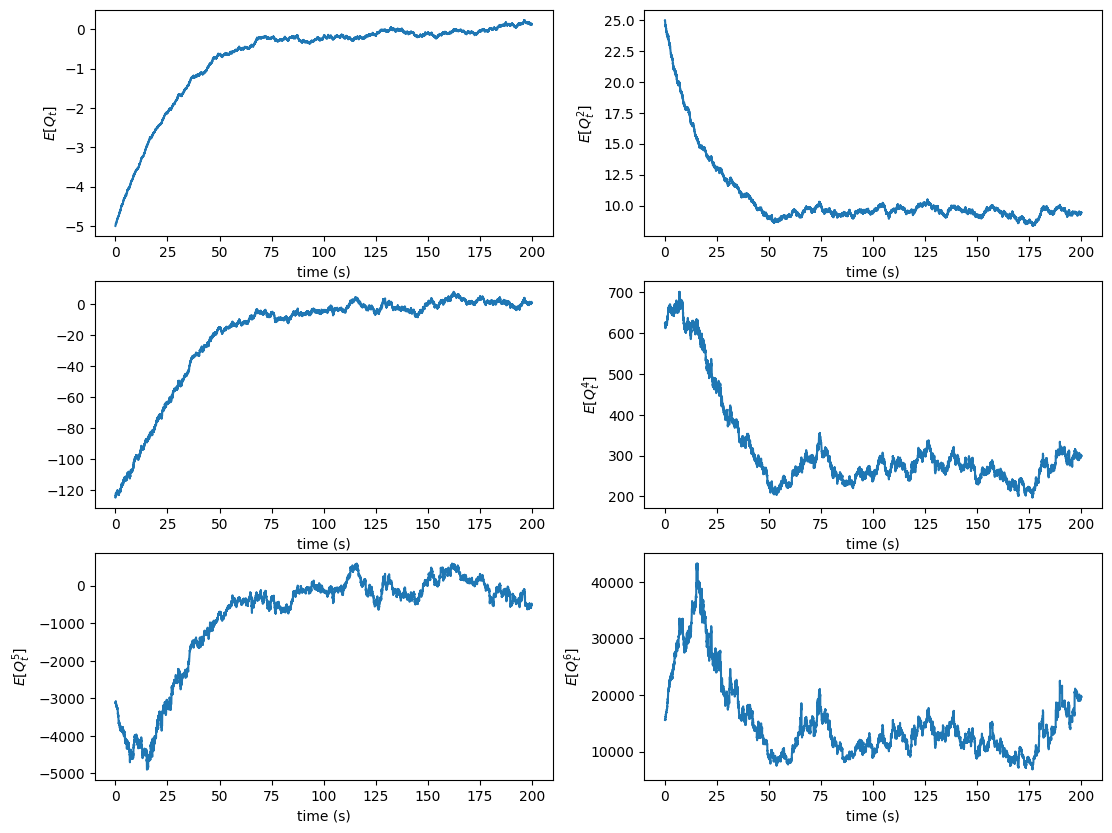

In [352]:
fig, ax = plt.subplots(3,2, figsize=(13,10))

ax[0,0].plot(t, torch.mean(res_de[:,:,3], axis=0))
ax[0,0].set_xlabel("time (s)")
ax[0,0].set_ylabel("$E[Q_t]$")

ax[0,1].plot(t, torch.mean(res_de[:,:,3]**2, axis=0))
ax[0,1].set_xlabel("time (s)")
ax[0,1].set_ylabel("$E[Q_t^2]$")

ax[1,0].plot(t, torch.mean(res_de[:,:,3]**3, axis=0))
ax[1,0].set_xlabel("time (s)")

ax[1,1].plot(t, torch.mean(res_de[:,:,3]**4, axis=0))
ax[1,1].set_xlabel("time (s)")
ax[1,1].set_ylabel("$E[Q_t^4]$")

ax[2,0].plot(t, torch.mean(res_de[:,:,3]**5, axis=0))
ax[2,0].set_xlabel("time (s)")
ax[2,0].set_ylabel("$E[Q_t^5]$")

ax[2,1].plot(t, torch.mean(res_de[:,:,3]**6, axis=0))
ax[2,1].set_xlabel("time (s)")
ax[2,1].set_ylabel("$E[Q_t^6]$")

plt.show()

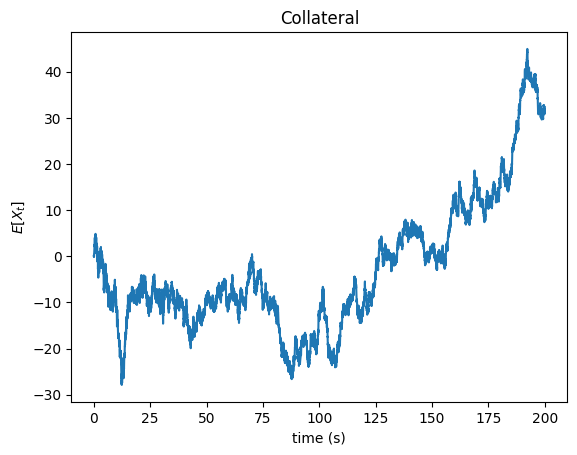

In [303]:
plt.plot(t, torch.mean(res_de[:,:,0], axis=0))
plt.xlabel("time (s)")
plt.ylabel("$E[X_t]$")
plt.title("Collateral")
plt.show()